In [1]:
import sys
if sys.argv[1] == 'xxx': pass
else: 
    %matplotlib inline

import os
import numpy
import pandas
import matplotlib
import matplotlib.pyplot
matplotlib.rcParams['font.family'] = 'Arial,freesans'

import necstdb

In [2]:
cwd = os.getcwd()
mode, date = cwd.split('/')[-2], cwd.split('/')[-1]

data_path = '/home/amigos/hdd/data/{mode}/{date}/'.format(**locals())

db = necstdb.opendb(data_path)

In [3]:
xffts_topics = [
        'xffts_board01',
        'xffts_board02',
        'xffts_board03',
        'xffts_board04',
        'xffts_board05', 
        'xffts_board06',
        'xffts_board07',
        'xffts_board08',
        'xffts_board09',
        'xffts_board10', 
        'xffts_board11',
        'xffts_board12',
        'xffts_board13', 
        'xffts_board14', 
        'xffts_board15',
        'xffts_board16',
]

hemt_topics = [
    'hemt_2l_vd',
    'hemt_2l_vg1',
    'hemt_2l_vg2',
    'hemt_2r_vd',
    'hemt_2r_vg1',
    'hemt_2r_vg2',
    'hemt_3l_vd',
    'hemt_3l_vg1',
    'hemt_3l_vg2',
    'hemt_3r_vd',
    'hemt_3r_vg1',
    'hemt_3r_vg2',
    'hemt_4l_vd',
    'hemt_4l_vg1',
    'hemt_4l_vg2',
    'hemt_4r_vd',
    'hemt_4r_vg1',
    'hemt_4r_vg2',
    'hemt_5l_vd',
    'hemt_5l_vg1',
    'hemt_5l_vg2',
    'hemt_5r_vd',
    'hemt_5r_vg1',
    'hemt_5r_vg2',    
]

In [4]:
xffts = {
    _: db.open_table(_).read(astype='array')
    for _ in xffts_topics
}

tp = {
    _: xffts[_]['spec'].sum(axis=1)
    for _ in xffts_topics
}

dt1 = {
    _: xffts[_]['timestamp'][1:] - xffts[_]['timestamp'][:-1]
    for _ in xffts_topics
}

dt2 = {
    _: xffts[_]['received_time'][1:] - xffts[_]['received_time'][:-1]
    for _ in xffts_topics
}

onoff = db.open_table('hemt_onoff_check-status').read(astype='array')

hemt = {
    _: db.open_table(_).read(astype='array')
    for _ in hemt_topics
}

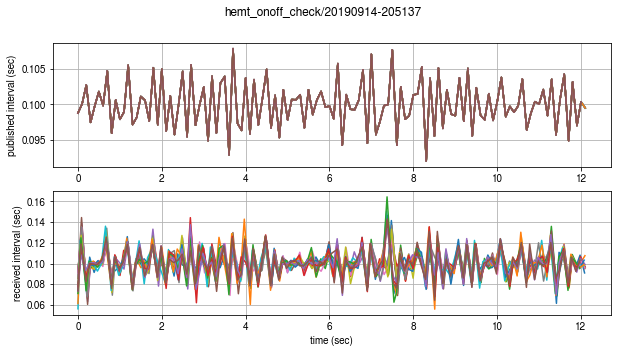

In [5]:
fig = matplotlib.pyplot.figure(figsize=(10,5))
ax = fig.add_subplot(2,1,1)
[ax.plot(xffts[_]['timestamp'][:-1] - xffts[_]['timestamp'][0], dt1[_]) for _ in xffts_topics]
ax.grid(True)
ax.set_ylabel('published interval (sec)')

ax = fig.add_subplot(2,1,2)
[ax.plot(xffts[_]['received_time'][:-1] - xffts[_]['received_time'][0], dt2[_]) for _ in xffts_topics]
ax.grid(True)
ax.set_xlabel('time (sec)')
ax.set_ylabel('received interval (sec)')

fig.suptitle(mode + '/' +date)
fig.savefig('t_interval.png')

In [6]:
margin = 1

off_start = onoff[onoff['data'] == b'OFF']['received_time'][0] + margin
off_stop = onoff[onoff['data'] == b'ON ']['received_time'][0] - margin
on_start = onoff[onoff['data'] == b'ON ']['received_time'][0] + margin
on_stop = onoff[onoff['data'] == b'OFF']['received_time'][1] - margin

off_start, off_stop, on_start, on_stop

(1568494300.3963096, 1568494303.797694, 1568494305.797694, 1568494308.7985654)

In [7]:
off_power = {
    _: tp[_][(off_start < xffts[_]['timestamp']) & (off_stop > xffts[_]['timestamp'])].mean()
    for _ in xffts_topics
}

on_power = {
    _: tp[_][(on_start < xffts[_]['timestamp']) & (on_stop > xffts[_]['timestamp'])].mean()
    for _ in xffts_topics
}

gain = {
    _: numpy.log10(on_power[_] / off_power[_]) * 10
    for _ in xffts_topics
}

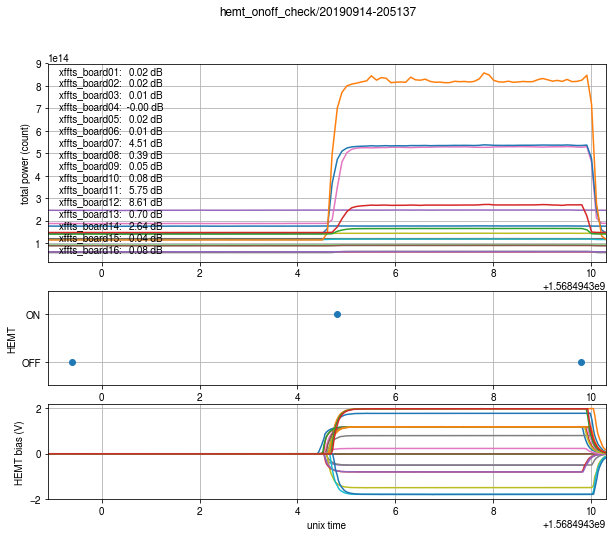

In [9]:
nrows = 4

maxx = numpy.max([
#     numpy.max([xffts[_]['timestamp'] for _ in xffts_topics]),
    numpy.max(onoff['received_time']),
]) + 0.5

minx = numpy.min([
#     numpy.min([xffts[_]['timestamp'] for _ in xffts_topics]),
    numpy.min(onoff['received_time']),
]) - 0.5



fig = matplotlib.pyplot.figure(figsize=(10,8))

ax = fig.add_subplot(2,1,1)
[ax.plot(xffts[_]['timestamp'], tp[_]) for _ in xffts_topics]
ax.grid(True)
ax.set_ylabel('total power (count)')
ax.set_xlim(minx, maxx)
[ax.text(0.02, 0.95-0.06*i, '{0}: {1:6.2f} dB'.format(_, gain[_]), transform=ax.transAxes) for i,_ in enumerate(xffts_topics)]

ax = fig.add_subplot(nrows,1,3)
onoff_ = []
for _ in onoff['data']:
    if _.find(b'ON')!=-1: onoff_.append(1)
    else: onoff_.append(0)
    continue
ax.plot(onoff['received_time'], onoff_, 'o')
ax.grid(True)
ax.set_ylim(-0.5, 1.5)
ax.set_yticks([0, 1])
ax.set_yticklabels(['OFF', 'ON'])
ax.set_ylabel('HEMT')
ax.set_xlim(minx, maxx)

ax = fig.add_subplot(nrows,1,4)
[ax.plot(hemt[_]['received_time'], hemt[_]['data']) for _ in hemt_topics]
ax.grid(True)
ax.set_ylabel('HEMT bias (V)')
ax.set_xlabel('unix time')
ax.set_xlim(minx, maxx)

fig.suptitle(mode + '/' +date)
fig.savefig('t_topics.png')

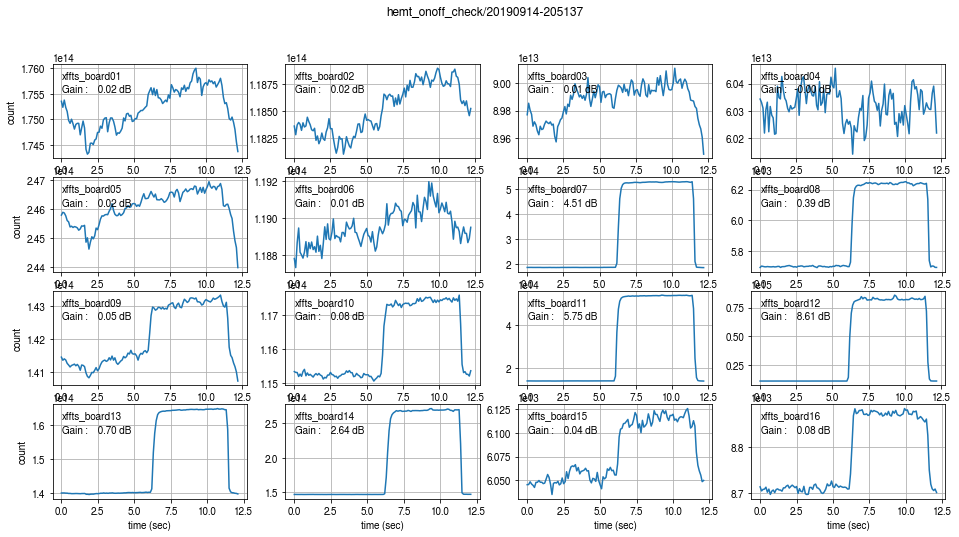

In [10]:
fig = matplotlib.pyplot.figure(figsize=(16,8))
ax =[fig.add_subplot(4,4, i) for i in range(1,17)]
for i,(_ax, _) in enumerate(zip(ax, xffts_topics)):
    _ax.plot(xffts[_]['timestamp'] - xffts[_]['timestamp'][0], tp[_])
    
    if i //4 == 3:
        _ax.set_xlabel('time (sec)')
    #_ax.set_yscale('log')
    if i%4 == 0:
        _ax.set_ylabel('count')
    _ax.text(0.05, 0.85, _, transform=_ax.transAxes)
    _ax.text(0.05, 0.7, 'Gain :  {0:6.2f} dB'.format(gain[_]), transform=_ax.transAxes)
    _ax.grid()

fig.suptitle(mode + '/' +date)
fig.savefig('total_power.png')


In [11]:
hemt_dict = {
    '2l': ['hemt_2l_vd','hemt_2l_vg1','hemt_2l_vg2'],
    '2r': ['hemt_2r_vd','hemt_2r_vg1','hemt_2r_vg2'],
    '3l': ['hemt_3l_vd','hemt_3l_vg1','hemt_3l_vg2'],
    '3r': ['hemt_3r_vd','hemt_3r_vg1','hemt_3r_vg2'],
    '4l': ['hemt_4l_vd','hemt_4l_vg1','hemt_4l_vg2'],
    '4r': ['hemt_4r_vd','hemt_4r_vg1','hemt_4r_vg2'],
    '5l': ['hemt_5l_vd','hemt_5l_vg1','hemt_5l_vg2'],
    '5r': ['hemt_5r_vd','hemt_5r_vg1','hemt_5r_vg2'],
}
h = {}
for hemt in hemt_dict:
    h[hemt] = {}
    for _hemt in hemt_dict[hemt]:
           h[hemt][_hemt] = db.open_table(_hemt).read(astype='array')

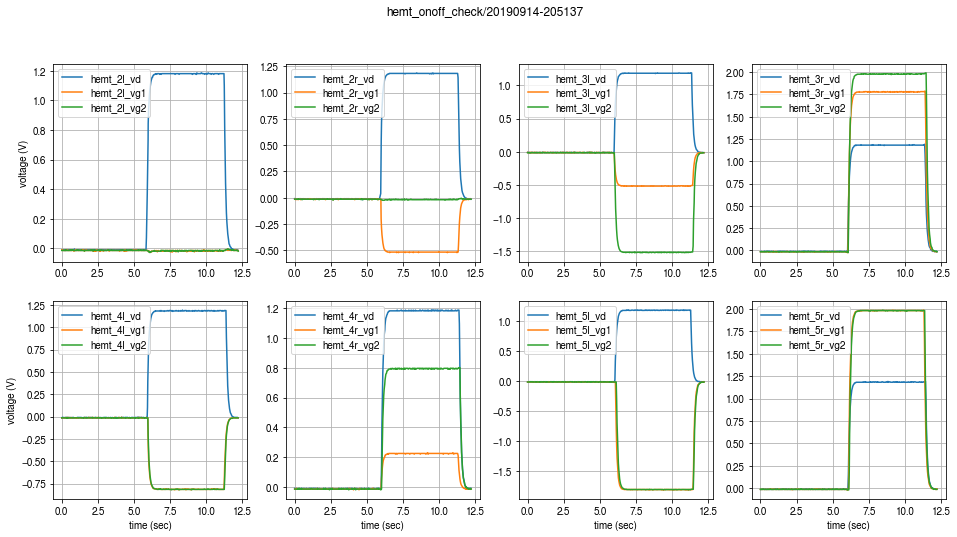

In [13]:
fig = matplotlib.pyplot.figure(figsize=(16,8))
ax =[fig.add_subplot(2,4, i) for i in range(1,9)]
for i,(_ax,hemt) in enumerate(zip(ax, hemt_dict)):
    for _hemt in hemt_dict[hemt]:
        _ax.plot(h[hemt][_hemt]['received_time'] - h[hemt][_hemt]['received_time'][0], h[hemt][_hemt]['data'], label=_hemt)
    if i//4 == 1:
        _ax.set_xlabel('time (sec)')
    if i%4 == 0: 
        _ax.set_ylabel('voltage (V)')
    #_ax.text(0.05, 0.9, hemt, transform=_ax.transAxes)
    _ax.grid()
    _ax.legend(loc='upper left')
fig.suptitle(mode + '/' +date)
fig.savefig('./hemt_.bias.png')